In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
print(os.getcwd())

/home/savvyfox/Projects/safe-control-gym/examples/rl


In [2]:
# data_paths = {"ppo": os.getcwd()+"/ppo_data/",
#              "sac": os.getcwd()+"/sac_data/"}
data_paths = {"ppo": os.getcwd()+"/Results/cartpole_ppo_data/", 
             "sac": os.getcwd()+"/Results/cartpole_sac_data/", 
             "td3": os.getcwd()+"/Results/cartpole_td3_data/", 
             "ddpg": os.getcwd()+"/Results/cartpole_ddpg_data/"}
seeds = [i for i in range(0,10)]


In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w)) / w
    
def load_from_log_file(path):
    '''Return x, y sequence data from the stat csv.'''
    with open(path, 'r') as f:
        lines = f.readlines()
    # Labels.
    xk, yk = [k.strip() for k in lines[0].strip().split(',')]
    # Values.
    x, y = [], []
    for line in lines[1:]:
        data = line.strip().split(',')
        x.append(float(data[0].strip()))
        y.append(float(data[1].strip()))
    x = np.array(x)
    y = np.array(y)
    return xk, x, yk, y

In [4]:
perf_data = {}
for method in data_paths.keys():
    print(method)
    perf_data.update({method: {}})
    for seed in seeds:
        xk, x, yk, y = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_return.log")
        xk, x, zk, z = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_return_std.log")
        xk, x, ck, c = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/constraint_violation.log")
        # perf_data[method].update({seed: {"x": x, "y": y, "c": c}})
        perf_data[method].update({seed: {"x": x, "y": y, "z": z, "c": c}})

ppo
sac
td3
ddpg


In [5]:
perf_data

{'ppo': {0: {'x': array([ 3000.,  6000.,  9000., 12000., 15000., 18000., 21000., 24000.,
          27000., 30000., 33000., 36000., 39000., 42000., 45000., 48000.]),
   'y': array([ -88.15775064, -110.80896017, -116.10320637, -119.46548994,
           -92.09106174,  -64.25393533,  -47.48677165,  -69.30662023,
           -60.30467331,  -88.17607396,  -23.59048325,  -90.87252346,
           -15.25030234,   -8.78282656,   -5.79158202,   -7.30442645]),
   'z': array([ 4.15811497, 23.13705735, 10.31592974,  8.94511162,  5.67150428,
          39.36820806, 31.65101058, 33.26866465, 30.23007339, 14.44750956,
          17.70665165,  2.97173683,  6.8311226 ,  1.72437304,  2.47379934,
           3.92283254]),
   'c': array([28.1, 28.2, 31.7, 34.4, 26.6, 14.7, 13.2, 17.9, 16.4, 23.1,  7. ,
          22.4,  2.9,  0.2,  0. ,  0. ])},
  1: {'x': array([ 3000.,  6000.,  9000., 12000., 15000., 18000., 21000., 24000.,
          27000., 30000., 33000., 36000., 39000., 42000., 45000., 48000.]),
   'y': arr

ppo
0
1
2
3
4
5
6
7
8
9
sac
0
1
2
3
4
5
6
7
8
9
td3
0
1
2
3
4
5
6
7
8
9
ddpg
0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, 'Task: Cartpole')

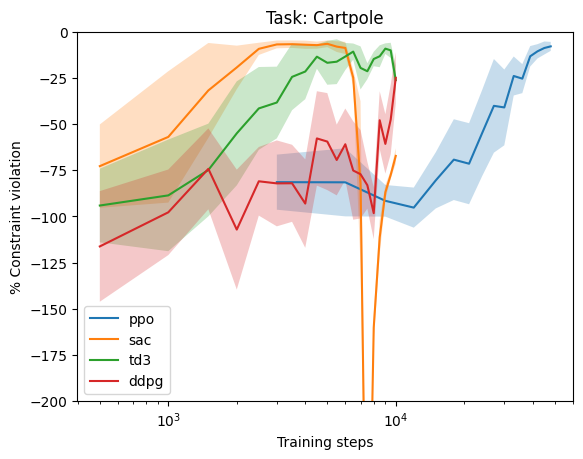

In [8]:
eval_data = {}
w = 1
fig = plt.figure()
for method in data_paths.keys():
    print(method)
    temp = np.zeros((len(seeds), 4, perf_data[method][seeds[0]]["x"].shape[0]))
    for seed in seeds:
        print(seed)
        temp[seed, 0, :] = perf_data[method][seed]["x"]
        temp[seed, 1, :] = perf_data[method][seed]["y"]
        temp[seed, 2, :] = perf_data[method][seed]["z"]
        temp[seed, 3, :] = perf_data[method][seed]["c"]
    eval_data.update({method: temp})

    # plotting performance
    plt.plot(temp[0,0,:], np.mean(temp[:,1,:], axis=0), label=method)
    plt.fill_between(temp[0,0,:], np.mean(temp[:,1,:], axis=0)+np.mean(temp[:,2,:], axis=0), 
                     np.mean(temp[:,1,:], axis=0)-np.mean(temp[:,2,:], axis=0), alpha=0.25)

    # plotting constraint violations
    # plt.plot(temp[0,0,:], np.mean(temp[:,3,:], axis=0), label=method)

# gp_05 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_0.5_cost.npy", allow_pickle=True)
# gp_10 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_1.0_cost.npy", allow_pickle=True)
# gp_30 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_3.0_cost.npy", allow_pickle=True)

# plt.plot(gp_05.item()["mean"][:,0], gp_05.item()["mean"][:,1], label="GP-MPC (m=0.5)")
# plt.fill_between(gp_05.item()["mean"][:,0], gp_05.item()["mean"][:,1]-gp_05.item()["std"], gp_05.item()["mean"][:,1]+gp_05.item()["std"], alpha=0.25)
# plt.plot(gp_10.item()["mean"][:,0], gp_10.item()["mean"][:,1], label="GP-MPC (m=1.0)")
# plt.fill_between(gp_10.item()["mean"][:,0], gp_10.item()["mean"][:,1]-gp_10.item()["std"], gp_10.item()["mean"][:,1]+gp_10.item()["std"], alpha=0.25)
# plt.plot(gp_30.item()["mean"][:,0], gp_30.item()["mean"][:,1], label="GP-MPC (m=3.0)")
# plt.fill_between(gp_30.item()["mean"][:,0], gp_30.item()["mean"][:,1]-gp_30.item()["std"], gp_30.item()["mean"][:,1]+gp_30.item()["std"], alpha=0.25)

# gp_05 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_0.5_constraint_percentage.npy", allow_pickle=True)
# gp_10 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_1.0_constraint_percentage.npy", allow_pickle=True)
# gp_30 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_3.0_constraint_percentage.npy", allow_pickle=True)
# plt.plot(gp_05.item()["mean"][:,0], gp_05.item()["mean"][:,1], label="GP-MPC (m=0.5)")
# plt.plot(gp_10.item()["mean"][:,0], gp_10.item()["mean"][:,1], label="GP-MPC (m=1.0)")
# plt.plot(gp_30.item()["mean"][:,0], gp_30.item()["mean"][:,1], label="GP-MPC (m=3.0)")


plt.legend()
plt.ylim(-200,0)
plt.xscale("log")
plt.xlabel("Training steps")
plt.ylabel("% Constraint violation")
plt.title("Task: Cartpole")
# plt.savefig("perf1.pdf",bbox_inches="tight", pad_inches=0.0)

Text(0.5, 1.0, 'Task: Cartpole')

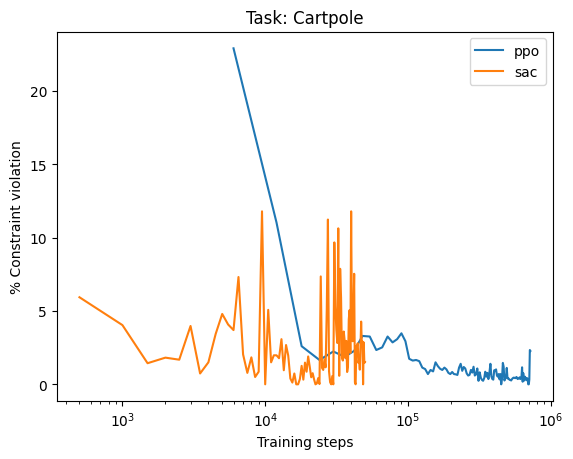

In [25]:
eval_data = {}
fig = plt.figure()
for method in data_paths.keys():
    temp = np.zeros((len(seeds), 4, perf_data[method][seeds[0]]["x"].shape[0]))
    for seed in seeds:
        temp[seed, 0, :] = perf_data[method][seed]["x"]
        temp[seed, 1, :] = perf_data[method][seed]["y"]
        # temp[seed, 2, :] = perf_data[method][seed]["z"]
        temp[seed, 3, :] = perf_data[method][seed]["c"]
    eval_data.update({method: temp})

    # plotting
    plt.plot(temp[0,0,:], np.mean(temp[:,3,:], axis=0), label=method)
    # plt.fill_between(temp[0,0,:], np.mean(temp[:,1,:], axis=0)+np.mean(temp[:,2,:], axis=0)**.5, np.mean(temp[:,1,:], axis=0)-np.mean(temp[:,2,:], axis=0)**0.5, alpha=0.25)
plt.legend()
# plt.ylim(0,10)
plt.xscale("log")
plt.xlabel("Training steps")
plt.ylabel("% Constraint violation")
plt.title("Task: Cartpole")
# plt.savefig("perf1.pdf",bbox_inches="tight", pad_inches=0.0)

In [54]:
gp_05 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_0.5_constraint_percentage.npy", allow_pickle=True)
gp_10 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_1.0_constraint_percentage.npy", allow_pickle=True)
gp_30 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_3.0_constraint_percentage.npy", allow_pickle=True)

gp_30.item()

{'mean': array([[ 0.00000000e+00,  0.00000000e+00],
        [ 2.93333333e+00,  0.00000000e+00],
        [ 5.80000000e+00,  0.00000000e+00],
        [ 8.73333333e+00,  0.00000000e+00],
        [ 1.16000000e+01,  0.00000000e+00],
        [ 1.62000000e+01,  7.13807821e-06],
        [ 2.00666667e+01,  5.61831177e-06],
        [ 2.40666667e+01, -2.38906074e-06],
        [ 2.82000000e+01, -1.02407836e-05],
        [ 3.20666667e+01, -8.33910976e-06],
        [ 3.60000000e+01, -1.04122867e-05],
        [ 4.01333333e+01, -7.54548368e-06],
        [ 4.42000000e+01, -1.02303621e-05],
        [ 4.80666667e+01, -5.04734446e-06],
        [ 5.20000000e+01, -1.68983074e-06],
        [ 5.60000000e+01, -9.74065818e-06],
        [ 6.00000000e+01,  2.63845694e-06],
        [ 6.42000000e+01, -2.09249434e-05],
        [ 6.81333333e+01, -5.47407624e-06],
        [ 7.22000000e+01, -6.64692476e-06],
        [ 7.60666667e+01,  1.17464305e-05],
        [ 8.02000000e+01,  3.14250987e-05],
        [ 8.40000000e+01